In [5]:
import pathlib
from PIL.Image import open as im_open, Image
import json
import PIL.Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
mode = "val"
data_mode = "modern"
image_dir = pathlib.Path(mode) / data_mode / "images"
ann_dir = pathlib.Path(mode) / data_mode / "annotations"
mask_dir = pathlib.Path(mode) / data_mode / "masks"
mask_dir.mkdir(exist_ok=True)

In [7]:
palette = []

for i in range(0, 64):
    palette.append(i) # R
    palette.append(i) # G
    palette.append(i) # B

for i in range(64, 128):
    palette.append(0) # R
    palette.append(0) # G
    palette.append(255) # B

for i in range(128, 192):
    palette.append(0) # R
    palette.append(255) # G
    palette.append(0) # B

for i in range(192, 256):
    palette.append(255) # R
    palette.append(0) # G
    palette.append(0) # B

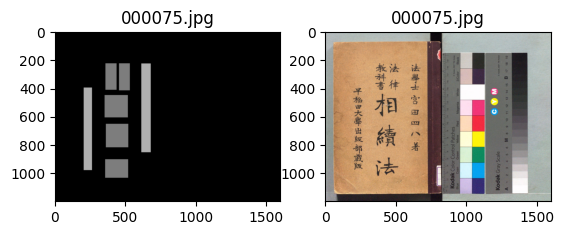

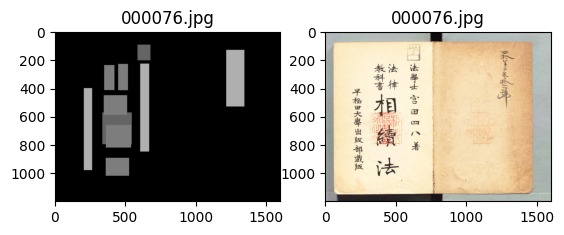

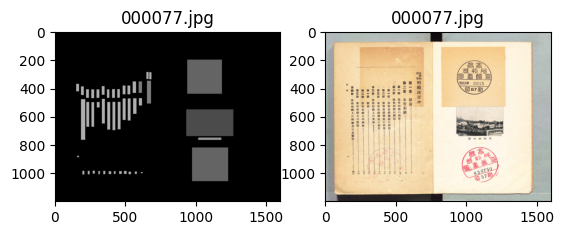

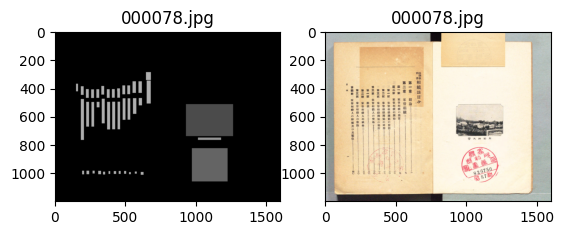

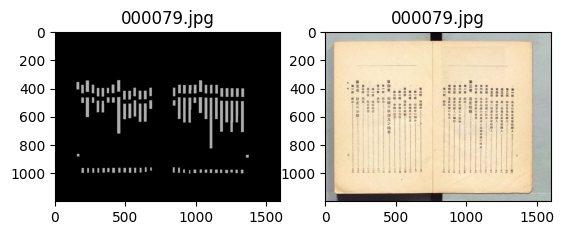

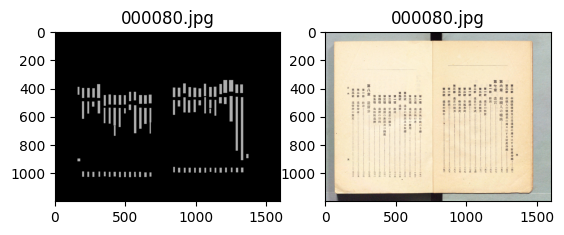

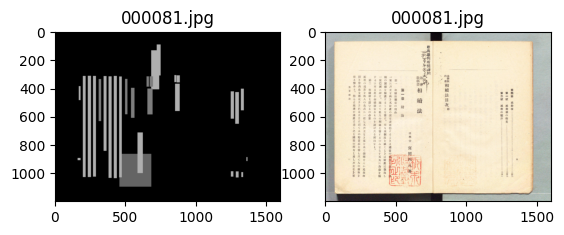

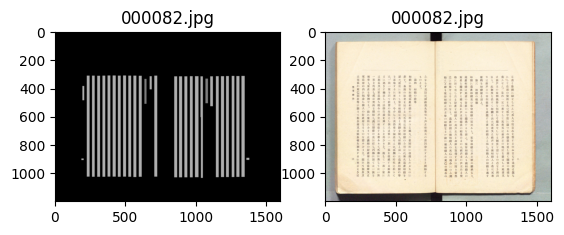

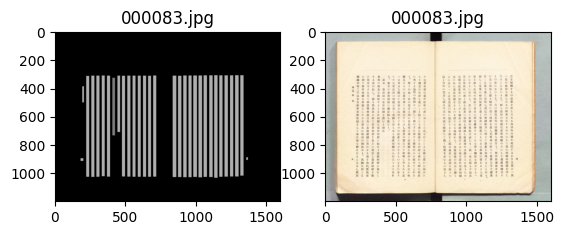

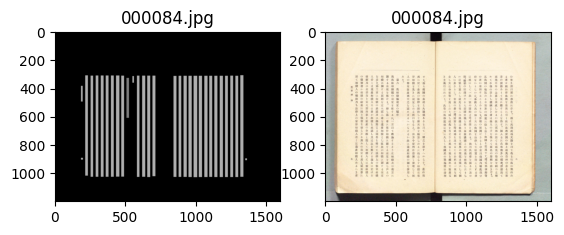

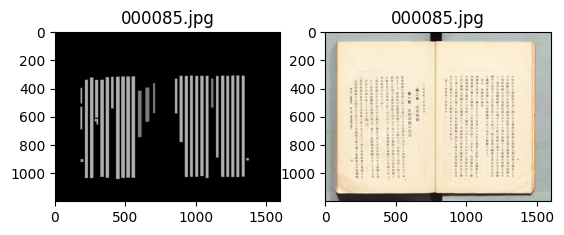

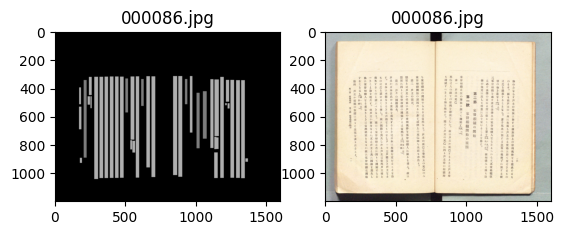

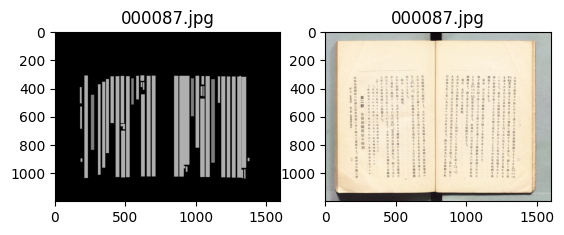

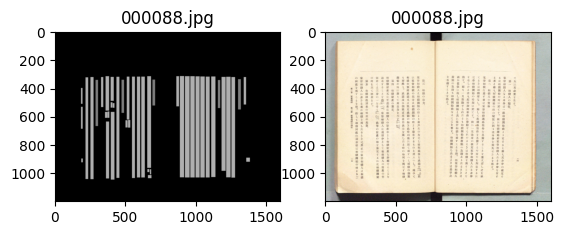

In [8]:
imgdirs = sorted(image_dir.iterdir())
anndirs = sorted(ann_dir.iterdir())
cnt = 0
for image_path, ann_path in zip(imgdirs, anndirs):
    # 画像サイズの取得
    img = im_open(image_path.as_posix()).convert("RGB")
    width, height = img.size
    # アノテーションのパース
    with ann_path.absolute().open() as f:
        ann = json.load(f)
        labels = ann["labels"]
        masks = np.array([[[0 for i in range(3)] for j in range(width)] for i in range(height)])
        for label in labels:
            category: str = label["category"]
            if data_mode == "modern":    
                if category == "1_overall" or category == "9_table":
                    continue
            elif data_mode == "old":
                if category == "1_overall":
                    continue
            boxes = [label["box2d"][key] for key in label["box2d"].keys()]            
            x_min, y_min, x_max, y_max = boxes
            # TODO: Speed up
            for x in range(x_min, min(width, x_max)):
                for y in range(y_min, min(height, y_max)):
                    if np.any(masks[y][x] != 0):
                        continue
                    pixel = (int(category[0]) - 1) * 25
                    assert pixel in [0, 25, 50, 75, 100, 125, 150, 175]
                    masks[y][x] = pixel

        mask_img = np.array(masks).astype(np.uint8)
        # print(np.unique(mask_img, return_counts=True))
        # mask_img = np.stack([mask_img, mask_img, mask_img], axis=0)
        # mask_img = mask_img.transpose(1, 2, 0).astype(np.uint8)
        mask_path = mask_dir / image_path.name
        cv2.imwrite(mask_path.as_posix(), mask_img)
        cnt += 1
        if cnt <= 14:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(mask_img)
            ax[1].imshow(img)
            ax[0].set_title(image_path.name)
            ax[1].set_title(image_path.name)     
            fig.show()
        else:
            continue
plt.show()    